# SYDE 556/750 --- Assignment 3
**Student ID: 20883350**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).

In [2]:
# copy code from A1
# note: The code below is for more than just Q1(b).
# I wrote a neuron interface class, and kept changing it as more questions arose
# these are the final neuron classes I came up with (and has code for more than just this section)

class Neuron:
    def __init__(self, a_max_range, zeta_range, r = 1):
        self.a_max = np.random.uniform(*a_max_range)
        self.r = r
        # note: zeta is already a computed dot product; it works in any dimension
        self.zeta = np.random.uniform(*zeta_range)
        self.e = self.compute_e()

        self.alpha = self.compute_alpha()
        self.J_bias = self.compute_J_bias()
        
    
    def x_to_J(self, x_samples):
        # input variable to current
        return self.alpha * (np.dot(self.e, x_samples)) + self.J_bias
    
    def compute_J_bias(self):
        pass

    def compute_alpha(self):
        pass

    def compute_e(self):
        pass
    
    def compute_firing_rate(self, x_samples):
        pass


class ReluNeuron(Neuron):
    def compute_e(self):
        return np.random.choice([-1, 1])
    def compute_J_bias(self):
        return (-self.a_max * self.zeta) / (1 - self.zeta)
    def compute_alpha(self):
        return self.a_max / (1 - self.zeta)
    def compute_firing_rate(self, x_samples):
        return np.maximum(self.x_to_J(x_samples), np.zeros(x_samples.shape[0]))


class LIFNeuron1D(Neuron):
    def __init__(self, a_max_range, zeta_range, tau_ref_ms, tau_rc_ms, r=1):
        self.tau_ref_s = tau_ref_ms / 1000
        self.tau_rc_s = tau_rc_ms / 1000
        super().__init__(a_max_range, zeta_range, r)

    def compute_e(self):
        return np.random.choice([-1, 1])
    def compute_J_bias(self):
        # assume alpha exists
        return 1 - self.alpha * self.zeta


    def compute_alpha(self):
        # no J_bias assumption
        return ((1 / (1 - np.exp((self.tau_ref_s - (1/self.a_max)) / self.tau_rc_s))) - 1) / (self.r - self.zeta)
    
    
    def compute_firing_rate(self, x_samples):
        J = self.x_to_J(x_samples)
        J_safe = np.where(J > 1, J, np.nan)  # Replace invalid J values with NaN
        return np.where(J > 1, 1 / (self.tau_ref_s - self.tau_rc_s * np.log(1 - (1 / J_safe))), 0)


class LIFNeuron2D(LIFNeuron1D):
    def __init__(self, a_max_range, zeta_range, tau_ref_ms, tau_rc_ms):
        super().__init__(a_max_range, zeta_range, tau_ref_ms, tau_rc_ms)
    
    def compute_e(self):
        # compute the encoder in 2D randomly, similar to 1D case
        # generate a random angle between 0 and 2 pi
        random_angle = np.random.uniform(0, 2 * np.pi)
        enc_x = np.cos(random_angle)
        enc_y = np.sin(random_angle)
        return np.array([enc_x, enc_y])

# this is a factory function to be able to create ant type of neuron from a common functon
def create_neuron(type, a_max_range = [100, 200], zeta_range = [-1, 1], tau_ref_ms = 2, tau_rc_ms = 20, r = 1):
    if type not in ["relu", "LIF", "LIF2D"]:
        raise TypeError("Neuron type must be relu or LIF")
    
    if type == "relu":
        return ReluNeuron(a_max_range, zeta_range)
    
    if type == "LIF":
        return LIFNeuron1D(a_max_range, zeta_range, tau_ref_ms, tau_rc_ms, r)
    
    if type == "LIF2D":
        return LIFNeuron2D(a_max_range, zeta_range, tau_ref_ms, tau_rc_ms)

def create_multiple_neuron_tuning_curves(x_samples, n_neurons, neuron_type, r=1, zeta_range = [-1, 1]):
    tuning_curves = []
    neurons = []
    for _ in range(n_neurons):
        neuron = create_neuron(neuron_type, r=r, zeta_range=zeta_range)
        neurons.append(neuron)
        tuning_curves.append(neuron.compute_firing_rate(x_samples))
    return tuning_curves, neurons

def plot_tuning_curves(x_samples, tuning_curves, title, x_label, y_label):
    for curve in tuning_curves:
        ax = sns.lineplot(x = x_samples, y = curve)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)


In [3]:
x_samples = np.linspace(-2, 2, num=81)
x_samples.shape[0]

81

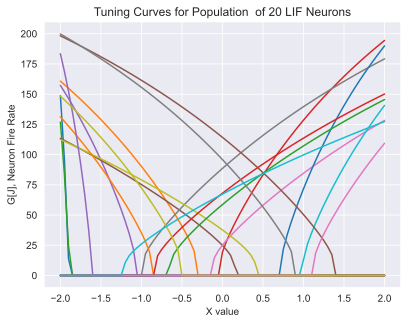

In [4]:
tuning_curves, neurons = create_multiple_neuron_tuning_curves(x_samples, 20, "LIF", r=2, zeta_range=[-2, 2])
plot_tuning_curves(x_samples, tuning_curves, "Tuning Curves for Population  of 20 LIF Neurons", "X value", "G[J], Neuron Fire Rate")

**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).

In [5]:
A = np.array([curve for curve in tuning_curves])
A.shape, np.max(A)

((20, 81), 199.81103496016854)

In [6]:
def plot_decoded_error(x, x_hat, title):
    rmse = np.sqrt(np.mean((x - x_hat) ** 2))
    ax = sns.lineplot(x = x, y = x - x_hat)
    ax.set_title(f"{title} (RMSE = {round(rmse, 4)})")
    ax.set_xlabel("Represented value x")
    ax.set_ylabel("Representation Error")

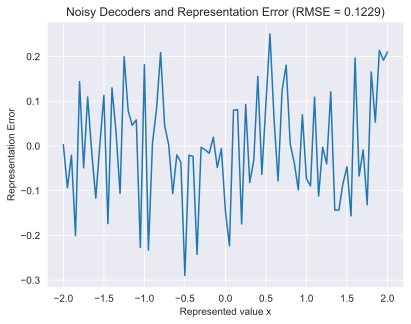

In [7]:
sigma = 0.1 * 200
D_solve_reg = lambda A, x, sigma: np.linalg.inv(A @ A.T + len(x) * sigma**2 * np.identity(A.shape[0])) @ A @ x.T

D_reg = D_solve_reg(A, x_samples, sigma)
E = np.random.normal(0, sigma, size=A.shape)
A_noise = A + E

x_hat = D_reg @ A_noise
plot_decoded_error(x_samples, x_hat, "Noisy Decoders and Representation Error")


In [8]:
D_reg.shape

(20,)

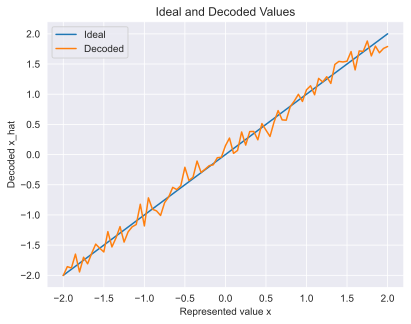

In [9]:
# overlay on plot for y = x
def plot_ideal_and_decoded_values(x, x_hat, title):
    sns.lineplot(x = x, y = x, label="Ideal")
    ax = sns.lineplot(x = x, y = x_hat, label="Decoded")
    plt.legend()
    ax.set_title(title)
    ax.set_xlabel("Represented value x")
    ax.set_ylabel("Decoded x_hat")
plot_ideal_and_decoded_values(x_samples, x_hat, "Ideal and Decoded Values")

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
		$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$

C = 5.5166555661265


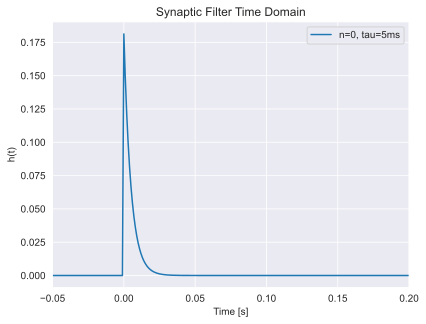

In [10]:
# copy code from a2
# Define constants
tau = 5e-3
t = np.arange(-0.5, 2, 1e-3)

# Define the filter function
def h(t, n, tau):
    # c = compute_c(n, tau)
    h_t_numerator = np.piecewise(
        t,  
        [t < 0, t >= 0],
        [0, lambda t: ((t**n) * np.exp(-t/tau))]
    ) 
    # normalize by dividing by sum of h_t
    c = np.sum(h_t_numerator)
    print(f"C = {c}")
    h_t = h_t_numerator / c
    return h_t

n = 0
h_t = h(t, n, tau)
# print(f"Area of filter: {quad(h, 0, np.inf, args=(n, tau))[0]}")
sns.lineplot(x=t, y=h_t, label=f'n={n}, tau={int(tau*10**3)}ms')  # Convert time to ms

plt.title('Synaptic Filter Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('h(t)')
plt.legend()
plt.grid(True)
plt.xlim(-0.05, 0.2)
plt.show()

Text(0.5, 1.0, 'Filter for convolution')

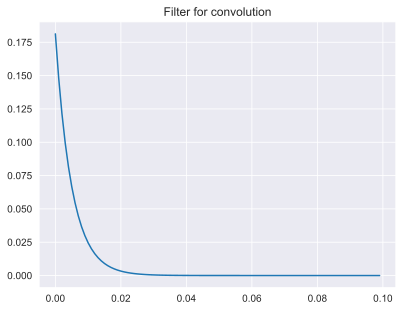

In [11]:
# index the filter in a range where it mostly exists (to use it in convolution)
indices = (t >= 0) & (t <= 0.1)
h_t_limited = h_t[indices]
sns.lineplot(x=t[indices], y=h_t_limited)
plt.title("Filter for convolution")

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.

In [12]:
# pick a neuron with firing rate between 20 and 50 hz for x=0
possible_neuron_i = []
for i, neuron in enumerate(neurons):
    y_intercept = neuron.compute_firing_rate(0)
    if 20  < y_intercept < 50:
        print(f"Neuron y-int: {y_intercept}")
        possible_neuron_i.append(i)
possible_neuron_i

Neuron y-int: 24.869058324181736
Neuron y-int: 25.10036289295559
Neuron y-int: 37.67743739082578


[5, 6, 8]

In [13]:
# select the neuron of choice
neuron = neurons[possible_neuron_i[2]]
print(neuron.compute_firing_rate(0))

37.67743739082578


In [14]:
alpha = neuron.alpha
J_bias = neuron.J_bias

# copy code to make a specialized neuron
class HardCodeNeuron:
    # create a specialized neuron which just takes alpha and J_bias values
    def __init__(self, alpha, J_bias, encoder):
        self.e = encoder
        self.J_bias = J_bias
        self.alpha = alpha
   
    def x_to_J(self, x_samples):
        # input variable to current
        return self.alpha * (np.dot(self.e, x_samples)) + self.J_bias
    
    def compute_J_bias(self):
        pass

    def compute_alpha(self):
        pass

    def compute_e(self):
        pass
    
    def compute_firing_rate(self, x_samples):
        pass


class HardCodeLIFNeuron1D(HardCodeNeuron):
    def __init__(self, alpha, J_bias, tau_ref_ms, tau_rc_ms, encoder):
        self.tau_ref_s = tau_ref_ms / 1000
        self.tau_rc_s = tau_rc_ms / 1000
        super().__init__(alpha, J_bias, encoder)

    def compute_firing_rate(self, x_samples):
        J = self.x_to_J(x_samples)
        J_safe = np.where(J > 1, J, np.nan)  # Replace invalid J values with NaN
        return np.where(J > 1, 1 / (self.tau_ref_s - self.tau_rc_s * np.log(1 - (1 / J_safe))), 0)

tau_rc_ms = 20
tau_ref_ms = 2
tau_ref_s = tau_ref_ms * 0.001
tau_rc_s = tau_rc_ms * 0.001
lif_neuron_positive = HardCodeLIFNeuron1D(alpha, J_bias, tau_ref_ms, tau_rc_ms, 1)
lif_neuron_negative = HardCodeLIFNeuron1D(alpha, J_bias, tau_ref_ms, tau_rc_ms, -1)

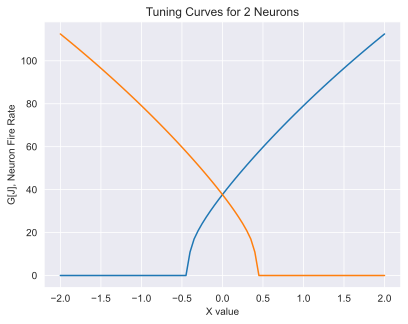

In [15]:
# plot the neurons
tuning_curves = [lif_neuron_positive.compute_firing_rate(x_samples), lif_neuron_negative.compute_firing_rate(x_samples)]
plot_tuning_curves(x_samples, tuning_curves, "Tuning Curves for 2 Neurons", "X value", "G[J], Neuron Fire Rate")

In [16]:
# copy code from a2
def generate_signal_limit(T, dt, rms, limit, seed):
    np.random.seed(seed)

    # change the frequency in hz to rad/s
    limit_w = 2 * np.pi * limit
    
    n_samples = int(T / dt)
    t_samples = np.linspace(0, T, n_samples)

    # find the frequencies which python will sample
    w_freq = 2 * np.pi * np.fft.fftfreq(n_samples, d=dt)

    # create an empty frequency signal
    signal_w = np.zeros(n_samples, dtype=complex)

    # at each frequency, sample a complex number X(w); only do it for the positive frequencies
    for i, w in enumerate(w_freq[:n_samples // 2]):
        if w <= limit_w:
            signal_w[i] = np.random.normal(0, 1) + 1j * np.random.normal(0, 1)
        # if the frequency is greater, leave the signal value at 0
    
    # make sure we only have real components
    # that is, we want X(w) = conj(X(-w))
    # we have X(w) thus we want conj(X(-w)) = X(w) => X(-w) = conj(X(w))
    # thus negative freq vals = conj positive freq vals
    signal_w[n_samples // 2 + 1:] = np.conj(signal_w[1:n_samples//2][::-1])
    
    # Inverse Fourier transform to get the time-domain signal
    signal_t = np.fft.ifft(signal_w).real
    
    # calculate the current rms of the generated signal
    curr_rms = np.sqrt(np.mean(signal_t**2))
    # we want the final rms to be rms
    # thus we want: rms = factor * curr_rms => factor = rms / curr_rms
    factor = rms / curr_rms
    signal_t *= factor
    signal_w *= factor

    # correctly shift the frequencies to 0-centrered
    w_freq = np.fft.fftshift(w_freq)
    signal_w = np.fft.fftshift(signal_w)
    
    return {"t": [t_samples, signal_t], "w": [w_freq, signal_w]}

def simulate_neuron(neuron, x_t, t_final, verbose=True):
    # create a script to run the simulation
    # TODO: consider makingn the top inputs parameters, especially dt
    v_rest = 0
    v_curr = 0
    v_th = 1
    t = 0
    dt = 0.001
    # set to -1 when not running
    t_curr_ref = -1

    # transpose it so that we go from D x N_t -> N_t x D.. so we can index it properly
    x_t = x_t.T

    n_spikes = 0
    voltages = [v_curr]
    t_array = [t]

    while t < t_final:
        # check if a neuron is in refractory time
        if t_curr_ref >= 0:
            t_curr_ref += dt
            t += dt
            voltages.append(v_curr)
            t_array.append(t)

            # check if we reached limit
            if t_curr_ref >= tau_ref_s:
                # reset the refractory time to -1
                t_curr_ref = -1
            continue

        # check if a neuron has spiked 
        if v_curr == (1 / dt):
            v_curr = 0
            t_curr_ref = dt
            t += dt
            voltages.append(v_curr)
            t_array.append(t)
            continue


        # calculate the voltage change using neuron J and current v
        # assume that the input is sampled in ms.. so the input at index [ms] is the current value of the input
        input_idx = int(t * 1000)
        dv_dt = (1 / tau_rc_s) * (neuron.x_to_J(x_t[input_idx]) - v_curr)

        # get only voltage change by taking time into accont
        dv = dv_dt * dt

        # update the current voltage
        v_curr += dv

        # if it's negative, reset to 0
        if v_curr < v_rest:
            v_curr = v_rest

        # if it's above the voltage threshold, generate a spike - indicate refractory time
        if v_curr >= v_th:
            # generate a discrete impulse
            v_curr = (1 / dt)
            n_spikes += 1

        # update the time to next time stamp
        t += dt
        voltages.append(v_curr)
        t_array.append(t)
    if verbose:
        print(f"The total number of spikes over {t_final} second is: {n_spikes}")
    return t_array, voltages

def v_to_spike(v, dt, true_spike=True):
    # converts an array of voltages to spikes
    spike_val = 1/dt
    output_val = spike_val if true_spike else 1
    spikes = [output_val if voltage == spike_val else 0 for voltage in v]
    return np.array(spikes)

In [17]:
# generate a white noise signal
T = 1
dt = 0.001
rms = 1
limit = 5
seed = 15
x_signals = generate_signal_limit(T, dt, rms, limit, seed)

t_pos_noise, v_pos_noise = simulate_neuron(lif_neuron_positive, x_signals["t"][1], T)
t_neg_noise, v_neg_noise = simulate_neuron(lif_neuron_negative, x_signals["t"][1], T)
# create the spike trains
pos_spikes = v_to_spike(v_pos_noise[:-1], 1e-3, true_spike=True)
neg_spikes = v_to_spike(v_neg_noise[:-1], 1e-3, true_spike=True)
pos_spikes_norm = v_to_spike(v_pos_noise[:-1], 1e-3, true_spike=False)
neg_spikes_norm = v_to_spike(v_neg_noise[:-1], 1e-3, true_spike=False)
spikes = np.array([pos_spikes, neg_spikes])

The total number of spikes over 1 second is: 33
The total number of spikes over 1 second is: 45


In [18]:
# solve for the decocoders; create A matrix
A = np.array([curve for curve in tuning_curves])
A.shape, np.max(A)

((2, 81), 112.48763234464614)

In [19]:
sigma = 0.1 * 200
D_reg = D_solve_reg(A, x_samples, sigma)
D_reg

array([ 0.01289429, -0.01289429])

In [20]:
np.dot(D_reg, spikes).shape

(1000,)

In [21]:
# don't account for any decoing factor as testing on multiple neuron amounts reveals this as the correct way
decoded_spikes = np.dot(D_reg, spikes)

In [22]:
# take the correspoding decoder from before
# flip the decoding sign since the original neuron has a negative encoding
# decoder = -D_reg[possible_neuron_i[2]]
# print(decoder)

# # take encoding into account to reconstruct the spike response
# decoded_spikes = (spikes[0] - spikes[1]) * decoder

In [23]:
x_signals["t"][0].shape, decoded_spikes.shape

((1000,), (1000,))

Text(0.5, 1.0, 'Decoded Output with No Filtering')

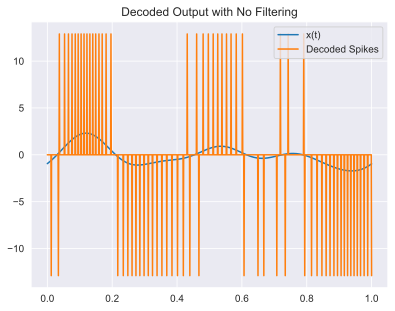

In [24]:
ax = sns.lineplot(x = x_signals["t"][0], y = x_signals["t"][1], label="x(t)")
sns.lineplot(x = x_signals["t"][0], y = decoded_spikes, label="Decoded Spikes")
ax.set_title("Decoded Output with No Filtering")

In [25]:
def filter_spikes(spikes, filter):
    return np.convolve(spikes, filter, mode="full")[:-(filter.size - 1)]

x_hat = filter_spikes(decoded_spikes, h_t_limited)
x_hat.shape, h_t_limited.shape

((1000,), (100,))

Text(0, 0.5, 'Signal Value')

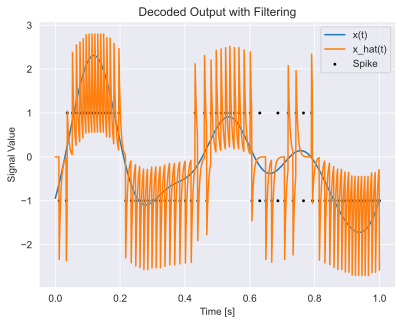

In [26]:
ax = sns.lineplot(x = x_signals["t"][0], y = x_signals["t"][1], label="x(t)")
sns.lineplot(x = x_signals["t"][0], y = x_hat, label="x_hat(t)")
sns.scatterplot(x = x_signals["t"][0][pos_spikes_norm == 1], y = pos_spikes_norm[pos_spikes_norm == 1], label="Spike", marker='o', s=10, color="black")
sns.scatterplot(x = x_signals["t"][0][neg_spikes_norm == 1], y = -neg_spikes_norm[neg_spikes_norm == 1], marker='o', s=10, color="black")
plt.legend()
ax.set_title("Decoded Output with Filtering")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Signal Value")

**c) Error analysis.** Compute the RMSE of the decoding.

In [27]:
rmse = np.sqrt(np.mean((x_signals["t"][1] - x_hat) ** 2))
print(f"RMSE: {rmse}")

RMSE: 0.7829159642830228


In [28]:
x_samples.shape

(81,)

# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.

Text(0, 0.5, 'Signal Value')

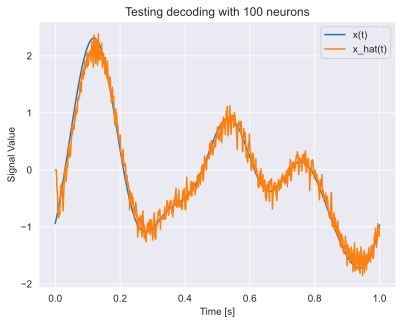

In [29]:
# test entire process with 100 neurons
tuning_curves, neurons = create_multiple_neuron_tuning_curves(x_samples, 100, "LIF", r=2, zeta_range=[-2, 2])
A = np.array([curve for curve in tuning_curves])
all_spikes = []
for neuron in neurons:
    t, v = simulate_neuron(neuron, x_signals["t"][1], T, verbose=False)
    spikes = v_to_spike(v[:-1], 1e-3, true_spike=True)
    all_spikes.append(spikes)

all_spikes = np.array(all_spikes)
sigma = 0.1 * 200
D_reg = D_solve_reg(A, x_samples, sigma)
decoded_spikes = np.dot(D_reg, all_spikes)
x_hat = filter_spikes(decoded_spikes, h_t_limited)

ax = sns.lineplot(x = x_signals["t"][0], y = x_signals["t"][1], label="x(t)")
sns.lineplot(x = x_signals["t"][0], y = x_hat, label="x_hat(t)")
ax.set_title("Testing decoding with 100 neurons")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Signal Value")

In [30]:
# create a function to compute the rmse given a number of neurons
def compute_rmse_for_n_neurons(x_samples, n_neurons):
    # create a random band limited white noise signal; x(t)
    T = 1
    dt = 0.001
    rms = 1
    limit = 5
    seed = 15
    x_signals_2 = generate_signal_limit(T, dt, rms, limit, seed)

    # create the neurons and their tuning curves
    tuning_curves, neurons = create_multiple_neuron_tuning_curves(x_samples, n_neurons, "LIF", r=2, zeta_range=[-2, 2])
    A = np.array([curve for curve in tuning_curves])
    all_spikes = []
    for neuron in neurons:
        # simulate the neuron on x(t)
        t, v = simulate_neuron(neuron, x_signals_2["t"][1], T, verbose=False)
        spikes = v_to_spike(v[:-1], 1e-3, true_spike=True)
        all_spikes.append(spikes)

    all_spikes = np.array(all_spikes)
    sigma = 0.1 * 200
    D_reg = D_solve_reg(A, x_samples, sigma)
    decoded_spikes = np.dot(D_reg, all_spikes)
    x_hat = filter_spikes(decoded_spikes, h_t_limited)

    # compute rmse between x_hat and x(t) generated
    return np.sqrt(np.mean((x_signals_2["t"][1] - x_hat) ** 2))


# create a function to compute the averaged error over multiple runs
def compute_rmse_for_n_neurons_averaged(x_samples, n_neurons, n_runs=5):
    all_rmse = []
    for i in range(n_runs):
        rmse = compute_rmse_for_n_neurons(x_samples, n_neurons)
        all_rmse.append(rmse)
        # print(f"Runs {i} had EDist: {E_dist} and ENoise: {E_noise}")

    all_rmse = np.array(all_rmse)
    return np.mean(all_rmse)

# create a function to compute errors for varying neuron amounnts
def compute_rmse_varying_n_neurons(varying_n_neurons, x_samples):
    rmse_by_n_neurons = []
    for n_neurons in varying_n_neurons:
        rmse_avg = compute_rmse_for_n_neurons_averaged(x_samples, n_neurons)
        rmse_by_n_neurons.append(rmse_avg)
    rmse_by_n_neurons = np.array(rmse_by_n_neurons)
    return rmse_by_n_neurons

In [31]:
n_neurons_range = np.array([2**n for n in range(3, 9)])
n_neurons_range

array([  8,  16,  32,  64, 128, 256])

In [32]:
rmse_by_n_neurons = compute_rmse_varying_n_neurons(n_neurons_range, x_samples)

In [33]:
def create_log_log_plot(x_data, y_data, x_label, y_label, title):
    ax = sns.lineplot(x = x_data, y = y_data, label="Error")
    sns.lineplot(x = x_data, y = 1/x_data, label="1/n")
    sns.lineplot(x = x_data, y = 1/(np.sqrt(x_data)), label="1/sqrt(n)")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

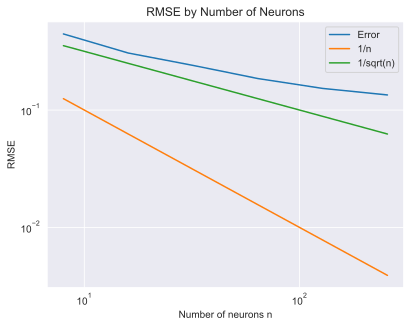

In [34]:
create_log_log_plot(n_neurons_range, rmse_by_n_neurons, "Number of neurons n", "RMSE", f"RMSE by Number of Neurons")

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?

The relationship between neuron count and error is shown as: the decrease in RMSE follows a 1/sqrt(n) relationship. This makes sense, as we know that an increasing neuron population is able to better encoder a given signal. Furthermore, it is in line with figure 5.3 in the book as it shows that MSE is proportional to 1/N => RMSE is proportional to 1/sqrt(n), as observed here. 

The relationship can be seen visually by comparing the x_hat from part 2 (with 2 neurons) to the other x_hat I created at the start of part 3, which has 100 neurons. Evidently, 100 neurons can encode the information in spiking neurons much better than 2 neurons can - and increasing numbers of spiking neurons are able to better encode any signal generated.

# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.

In [35]:
t = np.linspace(0, 1, 1001)
x_t = t - 1
x_t

array([-1.   , -0.999, -0.998, ..., -0.002, -0.001,  0.   ])

In [36]:
x_samples = np.linspace(-1, 1, num=41)
x_samples.shape

(41,)

In [37]:
tuning_curves_pop_A, neuron_pop_A = create_multiple_neuron_tuning_curves(x_samples, 200, "LIF")
A_pop_A = np.array([curve for curve in tuning_curves_pop_A])

# produce spikes for the population
all_spikes_A = []
for neuron in neuron_pop_A:
    # simulate the neuron on x(t)
    t, v = simulate_neuron(neuron, x_t, T, verbose=False)
    spikes = v_to_spike(v, 1e-3, true_spike=True)
    all_spikes_A.append(spikes)
all_spikes_A = np.array(all_spikes_A)
all_spikes_A.shape

(200, 1001)

In [38]:
# produce decoders for the transformation
sigma = 0.1 * 200
x_function = 2*x_samples + 1
D_reg_func = D_solve_reg(A_pop_A, x_function, sigma)
decoded_spikes_A = np.dot(D_reg_func, all_spikes_A)
fx_hat = filter_spikes(decoded_spikes_A, h_t_limited)
fx_hat.shape

(1001,)

In [39]:
# create the second group of neurons
y_samples = x_samples
tuning_curves_pop_B, neuron_pop_B = create_multiple_neuron_tuning_curves(y_samples, 200, "LIF")
A_pop_B = np.array([curve for curve in tuning_curves_pop_B])

# produce spikes for the second population
all_spikes_B = []
for neuron in neuron_pop_B:
    # simulate the neuron on the function fx_hat
    t, v = simulate_neuron(neuron, fx_hat, T, verbose=False)
    spikes = v_to_spike(v, 1e-3, true_spike=True)
    all_spikes_B.append(spikes)
all_spikes_B = np.array(all_spikes_B)
all_spikes_B.shape

(200, 1001)

In [40]:
# produce decoders for the output
sigma = 0.1 * 200
D_reg = D_solve_reg(A_pop_B, y_samples, sigma)
decoded_spikes_B = np.dot(D_reg, all_spikes_B)
y_hat = filter_spikes(decoded_spikes_B, h_t_limited)
y_hat.shape

(1001,)

Text(0, 0.5, 'Signal Value')

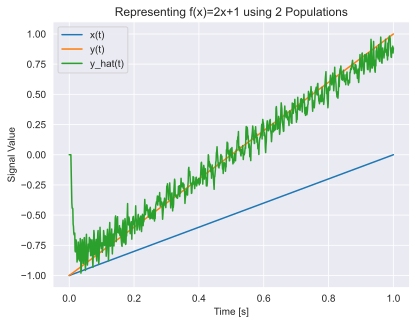

In [41]:
ax = sns.lineplot(x = t, y = x_t, label="x(t)")
sns.lineplot(x = t, y = 2*x_t+1, label="y(t)")
sns.lineplot(x = t, y = y_hat, label="y_hat(t)")
ax.set_title("Representing f(x)=2x+1 using 2 Populations")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Signal Value")

In [42]:
# create a function to simplify this process
def compute_function_spiking_pop(x_samples, n_neurons, neuron_type, t, x_t, x_func):
    tuning_curves, neuron_pop = create_multiple_neuron_tuning_curves(x_samples, n_neurons, neuron_type)
    A = np.array([curve for curve in tuning_curves])

    # produce spikes for the population
    all_spikes = []
    for neuron in neuron_pop:
        # simulate the neuron on x(t)
        # assume dt is hard coded as 0.001s
        _, v = simulate_neuron(neuron, x_t, t[-1], verbose=False)
        spikes = v_to_spike(v, 1e-3, true_spike=True)
        all_spikes.append(spikes)
    all_spikes = np.array(all_spikes)

    # produce decoders for the transformation
    sigma = 0.1 * 200
    y = x_func(x_samples)
    D_reg_func = D_solve_reg(A, y, sigma).T
    decoded_spikes = np.dot(D_reg_func, all_spikes)
    if len(decoded_spikes.shape) == 1:
        fx_hat = filter_spikes(decoded_spikes, h_t_limited)
    else:
        # we have multi-dim vector, filter individually
        filtered_spikes = []
        for spikes in decoded_spikes:
            filtered_spikes.append(filter_spikes(spikes, h_t_limited))
        fx_hat = np.stack(filtered_spikes)

    return fx_hat

In [43]:
x_t.T.shape

(1001,)

Text(0, 0.5, 'Signal Value')

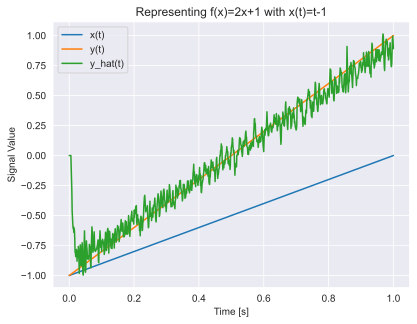

In [44]:
fx_hat_helper = compute_function_spiking_pop(x_samples, 200, "LIF", t, x_t, lambda x: 2*x + 1)
y_hat_helper = compute_function_spiking_pop(x_samples, 200, "LIF", t, fx_hat_helper, lambda y: y)

ax = sns.lineplot(x = t, y = x_t, label="x(t)")
sns.lineplot(x = t, y = 2*x_t+1, label="y(t)")
sns.lineplot(x = t, y = y_hat_helper, label="y_hat(t)")
ax.set_title("Representing f(x)=2x+1 with x(t)=t-1")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Signal Value")

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

Text(0.5, 1.0, 'Randomly Varying Step Input')

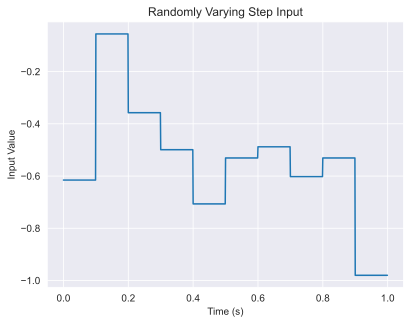

In [45]:
# Parameters
dt = 0.001  # Time step in seconds
num_values = 10  # Number of random step values
step_duration = 0.1  # Duration of each step in seconds

# Generate 10 random values between -1 and 0
random_values = np.random.uniform(-1, 0, num_values)

# Generate the time array from 0 to num_values * step_duration with a step size of dt
t = np.arange(0, num_values * step_duration, dt)

# Create the step input signal
x_values = np.zeros_like(t)
for i in range(num_values):
    start_index = int(i * step_duration / dt)
    end_index = int((i + 1) * step_duration / dt)
    x_values[start_index:end_index] = random_values[i]

# Plot the resulting step input
sns.lineplot(x=t, y=x_values)
plt.xlabel('Time (s)')
plt.ylabel('Input Value')
plt.title('Randomly Varying Step Input')

Text(0, 0.5, 'Signal Value')

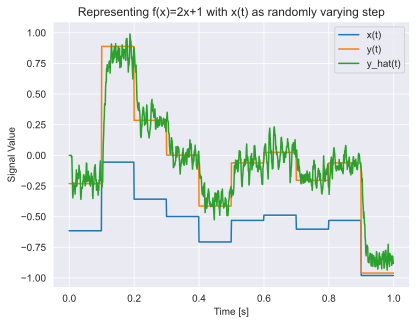

In [46]:
# now, decode this signal
fx_hat_2 = compute_function_spiking_pop(x_samples, 200, "LIF", t, x_values, lambda x: 2*x + 1)
y_hat_2 = compute_function_spiking_pop(x_samples, 200, "LIF", t, fx_hat_2, lambda y: y)

ax = sns.lineplot(x = t, y = x_values, label="x(t)")
sns.lineplot(x = t, y = 2*x_values+1, label="y(t)")
sns.lineplot(x = t, y = y_hat_2, label="y_hat(t)")
ax.set_title("Representing f(x)=2x+1 with x(t) as randomly varying step")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Signal Value")

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.

Text(0, 0.5, 'Signal Value')

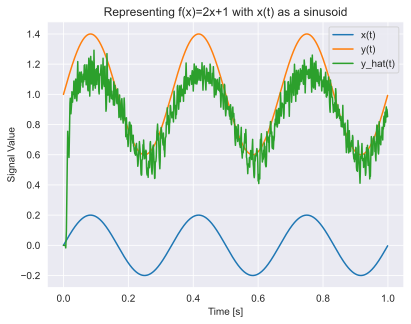

In [47]:
# now, decode this signal
sinusoidal_x = 0.2 * np.sin(6*np.pi*t)
fx_hat_3 = compute_function_spiking_pop(x_samples, 200, "LIF", t, sinusoidal_x, lambda x: 2*x + 1)
y_hat_3 = compute_function_spiking_pop(x_samples, 200, "LIF", t, fx_hat_3, lambda y: y)

ax = sns.lineplot(x = t, y = sinusoidal_x, label="x(t)")
sns.lineplot(x = t, y = 2*sinusoidal_x+1, label="y(t)")
sns.lineplot(x = t, y = y_hat_3, label="y_hat(t)")
ax.set_title("Representing f(x)=2x+1 with x(t) as a sinusoid")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Signal Value")

**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?

A few observations can be made. First off, the output generally does a good job at matching the ideal. In (a), we can see a linear function, with linear input being computed well and followed relatively well. In (b), the same linear function is being computed with step inputs - also doing a good job. And finally in (c), a linear function with sinusoidal input is being computed - also done well. One major deviation is at t = 0, where the y_hat always lags and starts at 0. This occurs because at t=0, there is no previous signal and no spikes - leading to a 0 start value. Furthermore, the post synaptic causal filter causes slight delays for the onset of a spike to respond, thus leading to a delayed behavior at the start. In (c), we can also see that the sinusoid is unable to reach the peak values. This is likely because the neurons have saturated their maximum firing rates. In general, we see some noise in the decodings, likely in part due to the noisy decoder computation. Finally, in (b), we see some errors when there are function discontinuities. These occur because the neurons we are using do not have the exact intercepts at these discontinuties, thus create deviations at these values. One more source of error are the decoders being computed - since we are using the rate approximation to compute the decoders, which we expect are quite similar. However, these are not the decoders computed via time - so they may vary from the optimal decoder value. Furthermore, some deviations may be a result of running a discrete simulation with time steps t = 0.001 (losing accuracy due to discretization).

# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).

In [48]:
# same idea as before, linear superposition is that... linear so we don't need to introduce any additional concepts. Currents will just add
# we use 3 gps of neurons with intercepts between [-1, 1]
t[0], t[-1], t.shape, x_samples.shape

(0.0, 0.999, (1000,), (41,))

In [49]:
x_t = np.cos(3*np.pi*t)
y_t = 0.5 * np.sin(2*np.pi*t)

fx_hat = compute_function_spiking_pop(x_samples, 200, "LIF", t, x_t, lambda x: 0.5*x)
fy_hat = compute_function_spiking_pop(x_samples, 200, "LIF", t, y_t, lambda y: 2*y)

# add results to feed into 3rd neuron group
fx_plus_y_hat = fx_hat + fy_hat

# third population just outputs the filtered result
fz_hat = compute_function_spiking_pop(x_samples, 200, "LIF", t, fx_plus_y_hat, lambda z: z)

Text(0, 0.5, 'Signal Value')

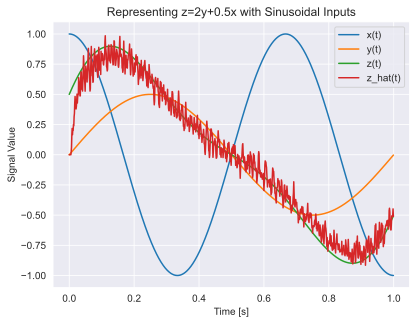

In [50]:
# plot the results
ax = sns.lineplot(x = t, y = x_t, label="x(t)")
sns.lineplot(x = t, y = y_t, label="y(t)")
sns.lineplot(x = t, y = 2*y_t + 0.5*x_t, label="z(t)")
sns.lineplot(x = t, y = fz_hat, label="z_hat(t)")
ax.set_title("Representing z=2y+0.5x with Sinusoidal Inputs")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Signal Value")

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.

In [51]:
t.shape

(1000,)

In [52]:
T = 1
dt = 0.001
rms = 1
limit = 8
x_t = generate_signal_limit(T, dt, rms, limit, seed)["t"][1]
limit = 5
rms = 0.5
y_t = generate_signal_limit(T, dt, rms, limit, seed)["t"][1]
x_t.shape, y_t.shape

((1000,), (1000,))

Text(0, 0.5, 'Signal Value')

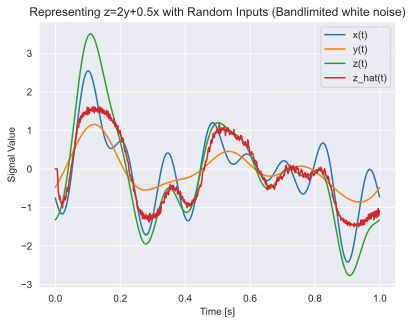

In [53]:
fx_hat = compute_function_spiking_pop(x_samples, 200, "LIF", t, x_t, lambda x: 0.5*x)
fy_hat = compute_function_spiking_pop(x_samples, 200, "LIF", t, y_t, lambda y: 2*y)

# add results to feed into 3rd neuron group
fx_plus_y_hat = fx_hat + fy_hat

# third population just outputs the filtered result
fz_hat = compute_function_spiking_pop(x_samples, 200, "LIF", t, fx_plus_y_hat, lambda z: z)

# plot the results
ax = sns.lineplot(x = t, y = x_t, label="x(t)")
sns.lineplot(x = t, y = y_t, label="y(t)")
sns.lineplot(x = t, y = 2*y_t + 0.5*x_t, label="z(t)")
sns.lineplot(x = t, y = fz_hat, label="z_hat(t)")
ax.set_title("Representing z=2y+0.5x with Random Inputs (Bandlimited white noise)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Signal Value")

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
		$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$

In [54]:
# create 2d x values for the rate model to operate on
y_samples = np.linspace(-1, 1, 41)
# use this to pass to my neuron
x_samples_2d = np.array([[x_sample, y_sample] for x_sample in x_samples for y_sample in y_samples]).T
x_samples_2d.shape

(2, 1681)

In [55]:
tuning_curves_2D, neuron_pop_2D = create_multiple_neuron_tuning_curves(x_samples_2d, 200, "LIF2D")
tuning_curves_2D[0].shape, neuron_pop_2D[0]

((1681,), <__main__.LIFNeuron2D at 0x1ef176b5e10>)

In [56]:
A_test_2D = np.array([curve for curve in tuning_curves_2D])
A_test_2D.shape

(200, 1681)

In [57]:
# create a sample signal, shape 2 x N_t
x_t_2d = np.ones((2, t.size))
x_t_2d.shape

(2, 1000)

In [58]:
# produce spikes for the population
all_spikes = []
for neuron in neuron_pop_2D:
    # simulate the neuron on x(t)
    # assume dt is hard coded as 0.001s
    _, v = simulate_neuron(neuron, x_t_2d, t[-1], verbose=False)
    spikes = v_to_spike(v, 1e-3, true_spike=True)
    all_spikes.append(spikes)
all_spikes = np.array(all_spikes)
all_spikes.shape

(200, 1000)

In [59]:
# produce decoders for the transformation
sigma = 0.1 * 200
# compute a vector which just doubles the result
y = 2 * x_samples_2d
D_reg_func_2D = D_solve_reg(A_test_2D, y, sigma).T
decoded_spikes = np.dot(D_reg_func_2D, all_spikes)
decoded_spikes.shape, D_reg_func_2D.shape

((2, 1000), (2, 200))

In [60]:
# fx_hat_2d_p1 = filter_spikes(decoded_spikes[0], h_t_limited)
# fx_hat_2d_p2 = filter_spikes(decoded_spikes[1], h_t_limited)
# fx_hat_2d_p1.shape, fx_hat_2d_p2.shape

In [61]:
# fx_hat_2d = np.stack([fx_hat_2d_p1, fx_hat_2d_p2])
# fx_hat_2d.shape

In [62]:
# code to filter multiple dimensions
filtered_spikes = []
for i, spikes in enumerate(decoded_spikes):
    # print(i)
    filtered_spikes.append(filter_spikes(spikes, h_t_limited))

fx_hat = np.stack(filtered_spikes)
fx_hat.shape

(2, 1000)

In [63]:
# test the new function
fx_hat = compute_function_spiking_pop(x_samples_2d, 200, "LIF2D", t, x_t_2d, lambda x: 0.65*x)
y_hat = compute_function_spiking_pop(x_samples_2d, 200, "LIF2D", t, fx_hat, lambda y: y)

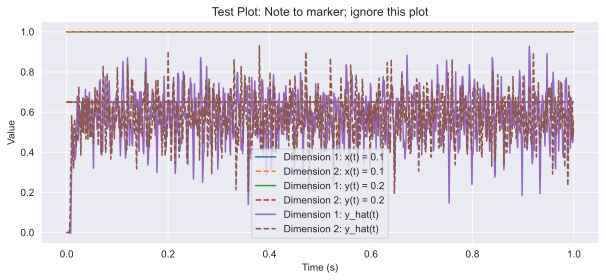

In [64]:
# Plot the function
plt.figure(figsize=(10, 4))
plt.plot(t, x_t_2d[0], label="Dimension 1: x(t) = 0.1")
plt.plot(t, x_t_2d[1], label="Dimension 2: x(t) = 0.1", linestyle='--')

plt.plot(t, 0.65*x_t_2d[0], label="Dimension 1: y(t) = 0.2")
plt.plot(t, 0.65*x_t_2d[1], label="Dimension 2: y(t) = 0.2", linestyle='--')

# plot the output
plt.plot(t, y_hat[0], label="Dimension 1: y_hat(t)")
plt.plot(t, y_hat[1], label="Dimension 2: y_hat(t)", linestyle='--')

# Customize the plot
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Test Plot: Note to marker; ignore this plot")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [65]:
# This is seemingly working on my sample/test 2D population. I will now try doing as the question says
x_const_2d = np.tile(np.array([[0.5], [1]]), (1, 1000))
y_const_2d = np.tile(np.array([[0.1], [0.3]]), (1, 1000))
z_const_2d = np.tile(np.array([[0.2], [0.1]]), (1, 1000))
q_const_2d = np.tile(np.array([[0.4], [-0.2]]), (1, 1000))
# x_const_2d, y_const_2d, z_const_2d, q_const_2d

In [66]:
fx_hat = compute_function_spiking_pop(x_samples_2d, 200, "LIF2D", t, x_const_2d, lambda x: x)
fy_hat = compute_function_spiking_pop(x_samples_2d, 200, "LIF2D", t, y_const_2d, lambda y: -3*y)
fz_hat = compute_function_spiking_pop(x_samples_2d, 200, "LIF2D", t, z_const_2d, lambda z: 2*z)
fq_hat = compute_function_spiking_pop(x_samples_2d, 200, "LIF2D", t, q_const_2d, lambda q: -2*q)

f_sum = fx_hat + fy_hat + fz_hat + fq_hat

w_hat = compute_function_spiking_pop(x_samples_2d, 200, "LIF2D", t, f_sum, lambda w: w)

(-1.5, 1.5)

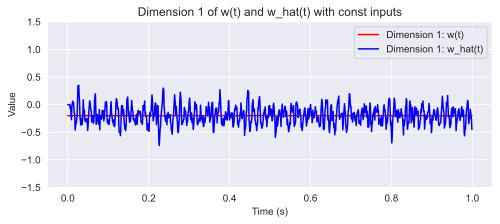

In [67]:
f_w = lambda x, y, z, q: x - 3*y + 2*z - 2*q
w = f_w(x_const_2d, y_const_2d, z_const_2d, q_const_2d)

plt.figure(figsize=(8, 3))
sns.lineplot(x=t, y=w[0], label="Dimension 1: w(t)", color='red')

sns.lineplot(x=t, y=w_hat[0], label="Dimension 1: w_hat(t)", color='blue')

# Customize the plot
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Dimension 1 of w(t) and w_hat(t) with const inputs")
plt.legend()
plt.grid(True)
plt.ylim(-1.5, 1.5)

(-1.5, 1.5)

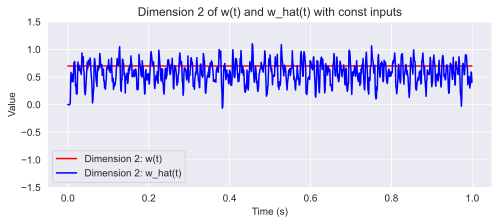

In [68]:
plt.figure(figsize=(8, 3))
sns.lineplot(x=t, y=w[1], label="Dimension 2: w(t)", color='red')
sns.lineplot(x=t, y=w_hat[1], label="Dimension 2: w_hat(t)", color='blue')

# Customize the plot
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Dimension 2 of w(t) and w_hat(t) with const inputs")
plt.legend()
plt.grid(True)
plt.ylim(-1.5, 1.5)

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$

In [69]:
sinusoid = np.sin(4*np.pi*t)
sinusoid.shape, np.repeat(0.3, sinusoid.size).shape

((1000,), (1000,))

In [70]:
y_t_sinusoidal_2d = np.stack([sinusoid, np.repeat(0.3, sinusoid.size)])
y_t_sinusoidal_2d.shape

(2, 1000)

In [71]:
q_t_sinusoidal_2d = np.stack([sinusoid, np.repeat(-0.2, sinusoid.size)])
q_t_sinusoidal_2d.shape

(2, 1000)

In [72]:
fx_hat = compute_function_spiking_pop(x_samples_2d, 200, "LIF2D", t, x_const_2d, lambda x: x)
fy_hat = compute_function_spiking_pop(x_samples_2d, 200, "LIF2D", t, y_t_sinusoidal_2d, lambda y: -3*y)
fz_hat = compute_function_spiking_pop(x_samples_2d, 200, "LIF2D", t, z_const_2d, lambda z: 2*z)
fq_hat = compute_function_spiking_pop(x_samples_2d, 200, "LIF2D", t, q_t_sinusoidal_2d, lambda q: -2*q)

f_sum = fx_hat + fy_hat + fz_hat + fq_hat

w_hat = compute_function_spiking_pop(x_samples_2d, 200, "LIF2D", t, f_sum, lambda w: w)

(-6.5, 6.5)

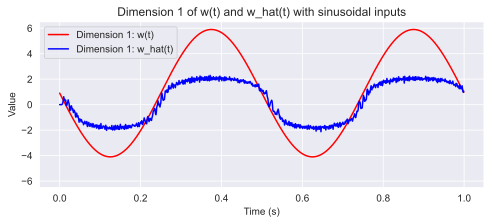

In [73]:
w = f_w(x_const_2d, y_t_sinusoidal_2d, z_const_2d, q_t_sinusoidal_2d)

plt.figure(figsize=(8, 3))
sns.lineplot(x=t, y=w[0], label="Dimension 1: w(t)", color='red')

sns.lineplot(x=t, y=w_hat[0], label="Dimension 1: w_hat(t)", color='blue')

# Customize the plot
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Dimension 1 of w(t) and w_hat(t) with sinusoidal inputs")
plt.legend()
plt.grid(True)
plt.ylim(-6.5, 6.5)

(-6.5, 6.5)

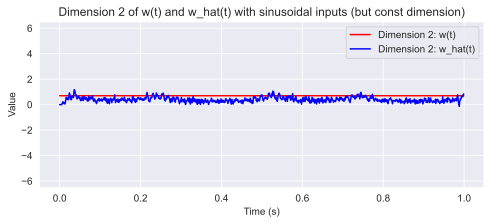

In [74]:
plt.figure(figsize=(8, 3))
sns.lineplot(x=t, y=w[1], label="Dimension 2: w(t)", color='red')
sns.lineplot(x=t, y=w_hat[1], label="Dimension 2: w_hat(t)", color='blue')

# Customize the plot
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Dimension 2 of w(t) and w_hat(t) with sinusoidal inputs (but const dimension)")
plt.legend()
plt.grid(True)
plt.ylim(-6.5, 6.5)

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.

In 6(a), we can see that the 2D vector representation is not bad, other than noise creeping in (from noisy neurons). Possible source of error are decoder computations through rate approximation, simulation running at a slower rate (0.001s step; not continuous), and effects of the filter which is an instance of a post synaptic filter (but definately not the optimal filter). Computing a fully flat function using noisy spikes is hard, which can be seen by the noise in the final decoding of w_hat. In 6(b), we can see that the neurons do a good job of transforming to match the sinusoidal input, but they saturate their firing rates and cannot reach the peaks or valleys of the sinusoid. Secondly, the dimension with the constant input (dim 2) seems to be pretty good as well, but has a slight sinusoidal pattern. This may be a result of the connections in the first dimensions slightly bleeding into the second dimension. The transformations are still relatively good given that spikes are the building blocks for all transformation. 